<a href="https://colab.research.google.com/github/ShivenTripathi/Dimensionality-Reduction-CGM/blob/main/Part_3/ColabNotebooks/DAE_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/gdrive/MyDrive/CGM
!ls
# !gzip "/content/drive/MyDrive/CGM/dataset/HIGGS_6M.csv.gz" -d "/content/drive/MyDrive/CGM/dataset"

In [ ]:
!pip install -U fastbook

      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


# Loading and processing dataset

* Standard Scaling
* Min Max Scaling

In [ ]:
df=pd.read_csv("dataset/HIGGS_6M.csv")
dataset=df.to_numpy()
X = dataset[:,1:]
Y = dataset[:,0].astype(int)
print(X[0],Y[0])
print(np.shape(X),np.shape(X[0]),np.shape(Y),np.shape(Y[0]))
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
categorical=[0,9,13,17,21]

for index in range(28):
  X[:,index]=scaler.fit_transform(X[:,index].reshape(-1,1)).reshape(-1)

scaler = MinMaxScaler()
for index in range(28):
  X[:,index]=scaler.fit_transform(X[:,index].reshape(-1,1)).reshape(-1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import fastbook
fastbook.setup_book()
from fastai.metrics import mse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from fastai import learner
from fastai.data import core
import time
from fastai.callback import schedule
import os
import numpy as np
from scipy import stats
import seaborn as sns

# Compiling DAE model

In [ ]:
class AE_4D_300_LeakyReLU(nn.Module):
    def __init__(self, n_features=28,bottle_neck=8):
        super(AE_4D_300_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 300)
        self.en2 = nn.Linear(300, 200)
        self.en3 = nn.Linear(200, 100)
        self.en4 = nn.Linear(100,50)
        self.en5 = nn.Linear(50, bottle_neck)
        self.de1 = nn.Linear(bottle_neck, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200,300)
        self.de5 = nn.Linear(300, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

model = AE_4D_300_LeakyReLU()
model.to('cpu')

AE_4D_300_LeakyReLU(
  (en1): Linear(in_features=28, out_features=300, bias=True)
  (en2): Linear(in_features=300, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=50, bias=True)
  (en5): Linear(in_features=50, out_features=8, bias=True)
  (de1): Linear(in_features=8, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=300, bias=True)
  (de5): Linear(in_features=300, out_features=28, bias=True)
  (tanh): Tanh()
)

# Loading DAE Model from Drive

In [ ]:
model_inf = AE_4D_300_LeakyReLU()
model_inf.to('cpu')
model_inf.load_state_dict(torch.load("dae_model/model.pth"))

<All keys matched successfully>

# Generating Encoded Input from DAE Model

You can skip this, next cell loads this from Drive

In [ ]:
from tqdm import tqdm

for i in tqdm(range(np.shape(X)[0]//10**6)):
  data = torch.tensor(X[i*(10**6):(i+1)*(10**6)], dtype=torch.float)
  pred = model_inf.encode(data)
  pred = pred.detach().numpy()
  pred = pred.T
  # pred = np.reshape(pred,(np.shape(pred)[0],1))
  if i is 0:
    x=pred
  # save(str(i)+'.npy', pred)
  else:
    x=np.concatenate((x,pred),axis=-1)
data = torch.tensor(X[(i+1)*(10**6):], dtype=torch.float)
pred = model_inf.encode(data)
pred = pred.detach().numpy()
pred = pred.T
x=np.concatenate((x,pred),axis=-1)

In [ ]:
print(np.shape(x))
x=x.T
print(np.shape(x))
np.save("encoded_x_6M.npy",x)
X = x
del x

(8, 5999999)
(5999999, 8)


In [ ]:
X = np.load("encoded_x_6M.npy")
print(np.shape(X), np.shape(Y))

(5999999, 8) (5999999,)


In [ ]:
test_size = 0.16
seed = 7
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=seed)

In [ ]:
print(np.shape(X_valid), np.shape(X_test), np.shape(X_train))
print(np.shape(y_valid), np.shape(y_test), np.shape(y_train))

(480000, 8) (480000, 8) (5039999, 8)
(480000,) (480000,) (5039999,)


# Training DNN Classifier on Encoded input

You can skip training, last cell loads the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import cross_val_score

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
baseline_history=model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_valid,y_valid))
model.summary()

Epoch 1/10
19688/19688 [==============================] - 126s 6ms/step - loss: 0.6803 - tp: 1006425.6283 - fp: 756422.2553 - tn: 428888.1120 - fn: 328583.9783 - accuracy: 0.5650 - precision: 0.5671 - recall: 0.7550 - auc: 0.5814 - val_loss: 0.6699 - val_tp: 198201.0000 - val_fp: 141172.0000 - val_tn: 84345.0000 - val_fn: 56282.0000 - val_accuracy: 0.5886 - val_precision: 0.5840 - val_recall: 0.7788 - val_auc: 0.6142
Epoch 2/10
19688/19688 [==============================] - 120s 6ms/step - loss: 0.6718 - tp: 989926.7178 - fp: 701245.0660 - tn: 484807.9776 - fn: 344340.2126 - accuracy: 0.5845 - precision: 0.5846 - recall: 0.7420 - auc: 0.6089 - val_loss: 0.6666 - val_tp: 184685.0000 - val_fp: 124510.0000 - val_tn: 101007.0000 - val_fn: 69798.0000 - val_accuracy: 0.5952 - val_precision: 0.5973 - val_recall: 0.7257 - val_auc: 0.6232
Epoch 3/10
19688/19688 [==============================] - 120s 6ms/step - loss: 0.6691 - tp: 984890.1769 - fp: 683756.6653 - tn: 501901.5898 - fn: 349771.5419

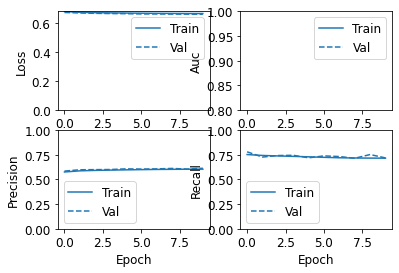

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

In [ ]:
BATCH_SIZE = 256

train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(True Negatives): ', cm[0][0])
  print('(False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print('(True Positives): ', cm[1][1])

loss :  0.6572193503379822
tp :  182473.0
fp :  115534.0
tn :  109986.0
fn :  72007.0
accuracy :  0.6092895865440369
precision :  0.6123111248016357
recall :  0.7170426249504089
auc :  0.646093487739563

(True Negatives):  109986
(False Positives):  115534
(False Negatives):  72007
(True Positives):  182473


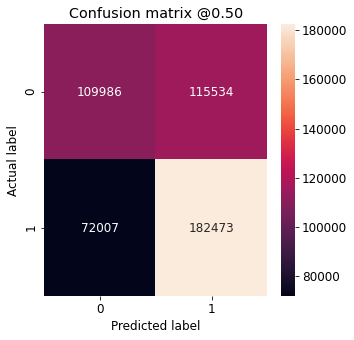

In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2,**kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  # plt.xlim([20,100])
  # plt.ylim([80,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

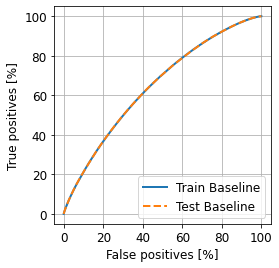

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import sklearn
plot_roc("Train Baseline",np.reshape(y_train,(np.shape(y_train)[0],1)),train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save("DNN_DAE_model")

INFO:tensorflow:Assets written to: DNN_DAE_model/assets


# Load DNN model from Drive

In [ ]:
model = keras.models.load_model('DNN_DAE_model')
